This workflow shown in this notebook is inspired by the following ressources:
- https://medium.com/swlh/facebook-prophet-426421f7e331
- https://medium.com/analytics-vidhya/time-series-tutorial-using-neuralprophet-e918a1b437ed
- https://medium.com/dropout-analytics/cross-validating-prophet-at-scale-72b1a21b6433
- https://medium.com/mlearning-ai/multivariate-time-series-forecasting-using-fbprophet-66147f049e66
- https://www.superdatascience.com/courses/data-science-for-business-case-studies/

# PROBLEM STATEMENT AND BUSINESS CASE


<table>
  <tr><td>
    <img 
        src="images/fig_1.jpg"
        alt="Fashion MNIST sprite"  width="1000">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1. Future Sales Time-series Prediction (with courtesy of: www.superdatascience.com) 
  </td></tr>
</table>

<table>
  <tr><td>
    <img 
        src="images/fig_2.jpg"
        alt="Fashion MNIST sprite"  width="1000">
  </td></tr>
  <tr><td align="center">
    <b>Figure 2. Problem Statement (with courtesy of: www.superdatascience.com) 
  </td></tr>
</table>


<table>
  <tr><td>
    <img 
        src="images/fig_3.jpg"
        alt="Fashion MNIST sprite"  width="1000">
  </td></tr>
  <tr><td align="center">
    <b>Figure 3. Problem Statement (with courtesy of: www.superdatascience.com) 
  </td></tr>
</table>

<table>
  <tr><td>
    <img 
        src="images/fig_4.jpg"
        alt="Fashion MNIST sprite"  width="1000">
  </td></tr>
  <tr><td align="center">
    <b>Figure 4. Inputs and Outputs (with courtesy of: www.superdatascience.com) 
  </td></tr>
</table>

<table>
  <tr><td>
    <img 
        src="images/fig_5.jpg"
        alt="Fashion MNIST sprite"  width="1000">
  </td></tr>
  <tr><td align="center">
    <b>Figure 5. Inputs and Outputs (with courtesy of: www.superdatascience.com) 
  </td></tr>
</table>

<table>
  <tr><td>
    <img 
        src="images/fig_6.jpg"
        alt="Fashion MNIST sprite"  width="1000">
  </td></tr>
  <tr><td align="center">
    <b>Figure 6. Inputs and Outputs (with courtesy of: www.superdatascience.com) 
  </td></tr>
</table>

# IMPORT LIBRARIES AND DATASET 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

In [2]:
# You have to include the full link to the csv file containing your dataset
sales_train_df = pd.read_csv('data/train.csv')

c:\Users\Nutzer\.conda\envs\ts_env\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
sales_train_df.head(5)
# almost a million observation 
# 1115 unique stores 
# Note that sales is the target variable (that's what we are trying to predict) 

# Id: transaction ID (combination of Store and date) 
# Store: unique store Id
# Sales: sales/day, this is the target variable 
# Customers: number of customers on a given day
# Open: Boolean to say whether a store is open or closed (0 = closed, 1 = open)
# Promo: describes if store is running a promo on that day or not
# StateHoliday: indicate which state holiday (a = public holiday, b = Easter holiday, c = Christmas, 0 = None)
# SchoolHoliday: indicates if the (Store, Date) was affected by the closure of public schools

#- Data Source: https://www.kaggle.com/c/rossmann-store-sales/data



,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [4]:
sales_train_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1


In [5]:
# lets check out how many stores we have
print('we identify {} different stores in the dataset!'.format(len(sales_train_df['Store'].unique())))

we identify 1115 different stores in the dataset!


In [6]:
# How many observations do we have per store?
sales_train_df[['Store', 'Sales']].groupby(by='Store').count()

,Sales
Store,
1,942
2,942
3,942
4,942
5,942
...,...
1111,942
1112,942
1113,942


In [7]:
# let´s check out the time series of store #1
sales_train_df[sales_train_df['Store']==1].sort_values(by='Date')

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
1016095,1,2,2013-01-01,0,0,0,0,a,1
1014980,1,3,2013-01-02,5530,668,1,0,0,1
1013865,1,4,2013-01-03,4327,578,1,0,0,1
1012750,1,5,2013-01-04,4486,619,1,0,0,1
1011635,1,6,2013-01-05,4997,635,1,0,0,1
...,...,...,...,...,...,...,...,...,...
4460,1,1,2015-07-27,6102,612,1,1,0,1
3345,1,2,2015-07-28,5011,560,1,1,0,1
2230,1,3,2015-07-29,4782,523,1,1,0,1
1115,1,4,2015-07-30,5020,546,1,1,0,1


In [8]:
sales_train_df.info()
# 9 columns in total 
# 8 features, each contains 1017209 data points
# 1 target variable (sales)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [9]:
sales_train_df.describe()
# Average sales amount per day = 5773 Euros, minimum sales per day = 0, maximum sales per day = 41551 
# Average number of customers = 633, minimum number of customers = 0, maximum number of customers = 7388

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


In [10]:
store_info_df = pd.read_csv('data/store.csv')

# StoreType: categorical variable to indicate type of store (a, b, c, d)
# Assortment: describes an assortment level: a = basic, b = extra, c = extended
# CompetitionDistance (meters): distance to closest competitor store
# CompetitionOpenSince [Month/Year]: provides an estimate of the date when competition was open
# Promo2: Promo2 is a continuing and consecutive promotion for some stores (0 = store is not participating, 1 = store is participating)
# Promo2Since [Year/Week]: date when the store started participating in Promo2
# PromoInterval: describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store




In [11]:
store_info_df.head(5)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [12]:
# Let's do the same for the store_info_df data
# Note that the previous dataframe includes the transactions recorded per day (in millions)
# This dataframe only includes information about the unique 1115 stores that are part of this study 
store_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [13]:
store_info_df.describe()
# on average, the competition distance is 5404 meters away (5.4 kms)

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.00000,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000
mean,558.00000,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573
std,322.01708,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935
min,1.00000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,279.50000,717.500000,4.000000,2006.000000,0.000000,13.000000,2011.000000
50%,558.00000,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000
75%,836.50000,6882.500000,10.000000,2013.000000,1.000000,37.000000,2013.000000
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


# EXPLORE DATASET

## Explore Dataset 1: Sales Data

<AxesSubplot:>

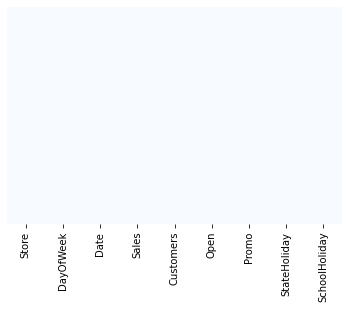

In [14]:
# Let's see if we have any missing data, luckily we don't!
# sns.heatmap(sales_train_df.isnull(), yticklabels = False, cbar = False, cmap="Blues")
sns.heatmap(sales_train_df.isnull(), yticklabels = False, cbar = False, cmap="Blues")


array([[<AxesSubplot:title={'center':'Store'}>,
        <AxesSubplot:title={'center':'DayOfWeek'}>,
        <AxesSubplot:title={'center':'Sales'}>],
       [<AxesSubplot:title={'center':'Customers'}>,
        <AxesSubplot:title={'center':'Open'}>,
        <AxesSubplot:title={'center':'Promo'}>],
       [<AxesSubplot:title={'center':'SchoolHoliday'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

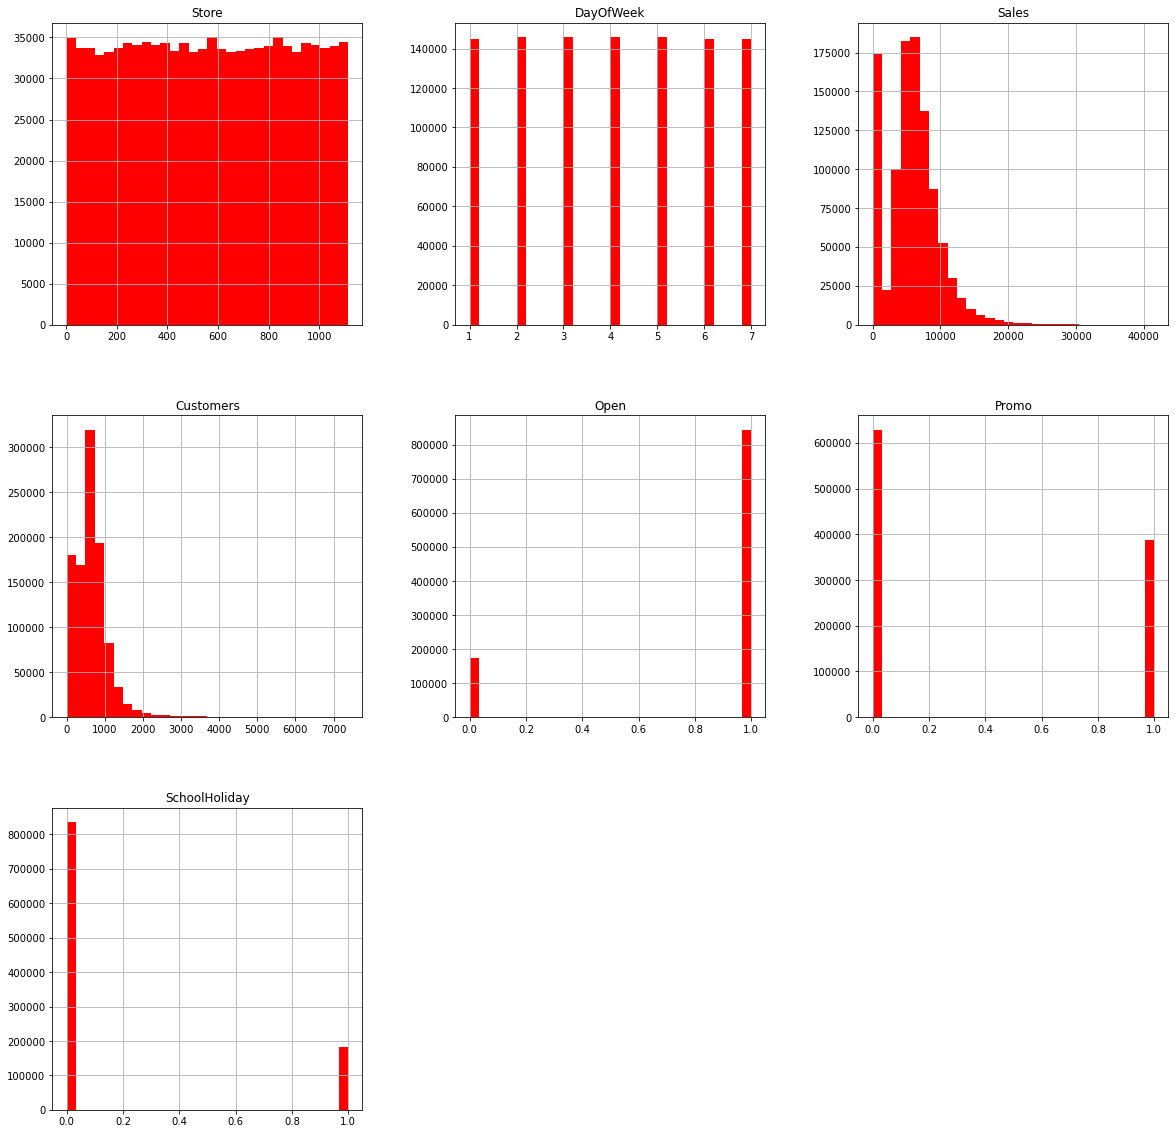

In [15]:
sales_train_df.hist(bins = 30, figsize = (20,20), color = 'r')
# Average 600 customers per day, maximum is 4500 (note that we can't see the outlier at 7388!)
# Data is equally distibuted across various Days of the week (~150000 observations x 7 day = ~1.1 million observation) 
# Stores are open ~80% of the time
# Data is equally distributed among all stores (no bias)
# Promo #1 was running ~40% of the time 
# Average sales around 5000-6000 Euros
# School holidays are around ~18% of the time



In [16]:
sales_train_df['Customers'].max()

7388

In [17]:
# Let's see how many stores are open and closed! 
closed_train_df        = sales_train_df[sales_train_df['Open'] == 0]
open_train_df          = sales_train_df[sales_train_df['Open'] == 1]


In [18]:
# Count the number of stores that are open and closed
print("Total =", len(sales_train_df))
print("Number of closed stores =", len(closed_train_df))
print("Number of open stores =", len(open_train_df))

Total = 1017209
Number of closed stores = 172817
Number of open stores = 844392


In [19]:
# only keep open stores and remove closed stores
sales_train_df = sales_train_df[sales_train_df['Open'] == 1]

In [20]:
sales_train_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1016776,682,2,2013-01-01,3375,566,1,0,a,1
1016827,733,2,2013-01-01,10765,2377,1,0,a,1
1016863,769,2,2013-01-01,5035,1248,1,0,a,1
1017042,948,2,2013-01-01,4491,1039,1,0,a,1


In [21]:
# Let's drop the open column since it has no meaning now
sales_train_df.drop(['Open'], axis=1, inplace=True)

c:\Users\Nutzer\.conda\envs\ts_env\lib\site-packages\pandas\core\frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [22]:
sales_train_df

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,0,1
1,2,5,2015-07-31,6064,625,1,0,1
2,3,5,2015-07-31,8314,821,1,0,1
3,4,5,2015-07-31,13995,1498,1,0,1
4,5,5,2015-07-31,4822,559,1,0,1
...,...,...,...,...,...,...,...,...
1016776,682,2,2013-01-01,3375,566,0,a,1
1016827,733,2,2013-01-01,10765,2377,0,a,1
1016863,769,2,2013-01-01,5035,1248,0,a,1
1017042,948,2,2013-01-01,4491,1039,0,a,1


In [23]:
sales_train_df.describe()
# Average sales = 6955 Euros,	average number of customers = 762	(went up)

,Store,DayOfWeek,Sales,Customers,Promo,SchoolHoliday
count,844392.000000,844392.000000,844392.000000,844392.000000,844392.000000,844392.000000
mean,558.422920,3.520361,6955.514291,762.728395,0.446352,0.193580
std,321.731914,1.723689,3104.214680,401.227674,0.497114,0.395103
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,280.000000,2.000000,4859.000000,519.000000,0.000000,0.000000
50%,558.000000,3.000000,6369.000000,676.000000,0.000000,0.000000
75%,837.000000,5.000000,8360.000000,893.000000,1.000000,0.000000
max,1115.000000,7.000000,41551.000000,7388.000000,1.000000,1.000000


## Explore Dataset 2: Store Information

In [24]:
store_info_df.isnull()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,False,False,False,False,False,False,False,True,True,True
1,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,True,True,True
4,False,False,False,False,False,False,False,True,True,True
...,...,...,...,...,...,...,...,...,...,...
1110,False,False,False,False,False,False,False,False,False,False
1111,False,False,False,False,False,False,False,True,True,True
1112,False,False,False,False,True,True,False,True,True,True
1113,False,False,False,False,True,True,False,True,True,True


<AxesSubplot:>

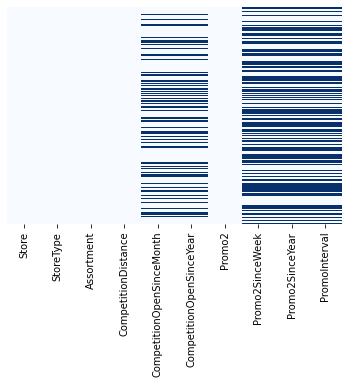

In [25]:
# Let's see if we have any missing data in the store information dataframe!
sns.heatmap(store_info_df.isnull(), yticklabels = False, cbar = False, cmap="Blues")


In [26]:
# Let's take a look at the missing values in the 'CompetitionDistance'
# Only 3 rows are missing 
store_info_df[store_info_df['CompetitionDistance'].isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


In [27]:
# Let's take a look at the missing values in the 'CompetitionOpenSinceMonth'
# many rows are missing = 354 (almost one third of the 1115 stores)
store_info_df[store_info_df['CompetitionOpenSinceMonth'].isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
11,12,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
12,13,d,a,310.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
15,16,a,c,3270.0,NaN,NaN,0,NaN,NaN,NaN
18,19,a,c,3240.0,NaN,NaN,1,22.0,2011.0,"Mar,Jun,Sept,Dec"
21,22,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"
...,...,...,...,...,...,...,...,...,...,...
1095,1096,a,c,1130.0,NaN,NaN,1,10.0,2014.0,"Mar,Jun,Sept,Dec"
1099,1100,a,a,540.0,NaN,NaN,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


In [28]:
store_info_df[ store_info_df['Promo2'] == 0]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
5,6,a,a,310.0,12.0,2013.0,0,NaN,NaN,NaN
6,7,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1107,1108,a,a,540.0,4.0,2004.0,0,NaN,NaN,NaN
1109,1110,c,c,900.0,9.0,2010.0,0,NaN,NaN,NaN
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN


In [29]:
# It seems like if 'promo2' is zero, 'promo2SinceWeek', 'Promo2SinceYear', and 'PromoInterval' information is set to zero
# There are 354 rows where 'CompetitionOpenSinceYear' and 'CompetitionOpenSinceMonth' is missing
# Let's set these values to zeros 
str_cols = ['Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth']

for str in str_cols:
    store_info_df [str].fillna(0, inplace = True)

<AxesSubplot:>

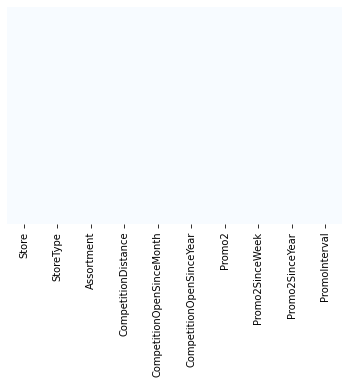

In [30]:
sns.heatmap(store_info_df.isnull(), yticklabels = False, cbar = False, cmap="Blues")


In [31]:
# There are 3 rows with 'competitionDistance' values missing, let's fill them up with with average values of the 'CompetitionDistance' column
store_info_df['CompetitionDistance'].fillna(store_info_df['CompetitionDistance'].mean(), inplace = True)

<AxesSubplot:>

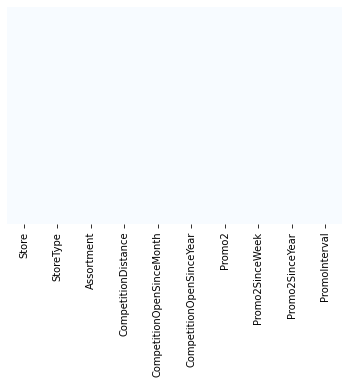

In [32]:
sns.heatmap(store_info_df.isnull(), yticklabels = False, cbar = False, cmap="Blues")

array([[<AxesSubplot:title={'center':'Store'}>,
        <AxesSubplot:title={'center':'CompetitionDistance'}>,
        <AxesSubplot:title={'center':'CompetitionOpenSinceMonth'}>],
       [<AxesSubplot:title={'center':'CompetitionOpenSinceYear'}>,
        <AxesSubplot:title={'center':'Promo2'}>,
        <AxesSubplot:title={'center':'Promo2SinceWeek'}>],
       [<AxesSubplot:title={'center':'Promo2SinceYear'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

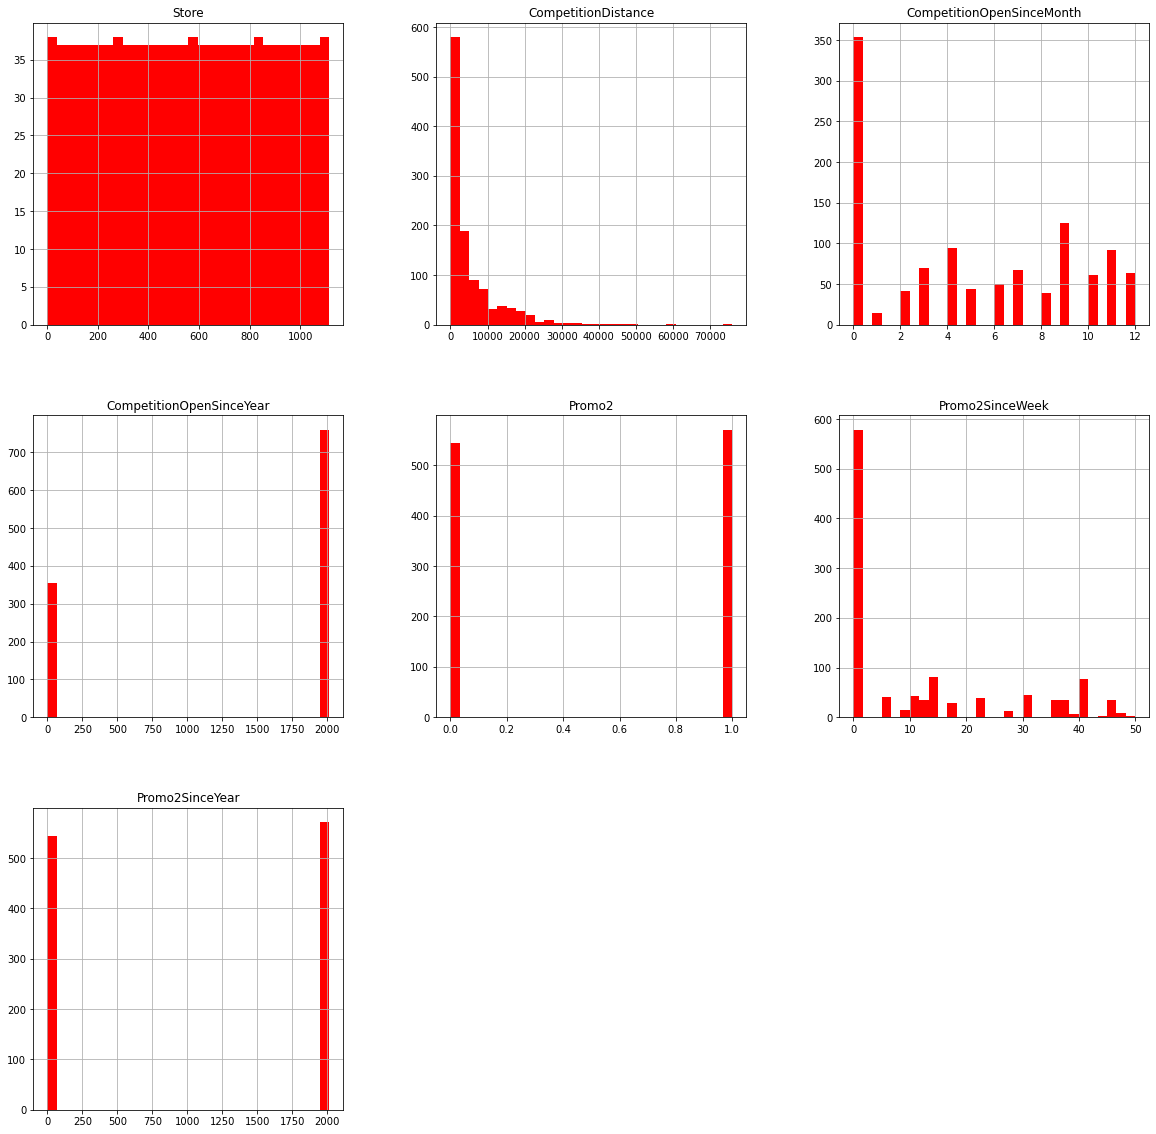

In [33]:
store_info_df.hist(bins = 30, figsize = (20,20), color = 'r')
# half of stores are involved in promo 2
# half of the stores have their competition at a distance of 0-3000m (3 kms away)

## Explore Merged Dataset 

In [34]:
sales_train_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,0,1
1,2,5,2015-07-31,6064,625,1,0,1
2,3,5,2015-07-31,8314,821,1,0,1
3,4,5,2015-07-31,13995,1498,1,0,1
4,5,5,2015-07-31,4822,559,1,0,1


In [35]:
store_info_df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,0.0,0.0,0
4,5,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0


In [36]:
# Let's merge both data frames together based on 'store'
sales_train_all_df = pd.merge(sales_train_df, store_info_df, how = 'inner', on = 'Store') 

In [37]:
sales_train_all_df.to_csv('data/test.csv', index=False)

In [38]:
sales_train_all_df

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,2015-07-30,5020,546,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,2015-07-29,4782,523,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,2015-07-28,5011,560,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,2015-07-27,6102,612,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844387,292,1,2013-01-07,9291,1002,1,0,0,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0
844388,292,6,2013-01-05,2748,340,0,0,0,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0
844389,292,5,2013-01-04,4202,560,0,0,1,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0
844390,292,4,2013-01-03,4580,662,0,0,1,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0


In [39]:
sales_train_all_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844392 entries, 0 to 844391
Data columns (total 17 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Store                      844392 non-null  int64  
 1   DayOfWeek                  844392 non-null  int64  
 2   Date                       844392 non-null  object 
 3   Sales                      844392 non-null  int64  
 4   Customers                  844392 non-null  int64  
 5   Promo                      844392 non-null  int64  
 6   StateHoliday               844392 non-null  object 
 7   SchoolHoliday              844392 non-null  int64  
 8   StoreType                  844392 non-null  object 
 9   Assortment                 844392 non-null  object 
 10  CompetitionDistance        844392 non-null  float64
 11  CompetitionOpenSinceMonth  844392 non-null  float64
 12  CompetitionOpenSinceYear   844392 non-null  float64
 13  Promo2                     84

In [40]:
correlations = sales_train_all_df.corr()['Sales'].sort_values()
correlations

# customers and promo are positively correlated with the sales 
# Promo2 does not seem to be effective at all 

DayOfWeek                   -0.178736
Promo2SinceYear             -0.127621
Promo2                      -0.127596
Promo2SinceWeek             -0.058476
CompetitionDistance         -0.036343
CompetitionOpenSinceMonth   -0.018370
CompetitionOpenSinceYear     0.005266
Store                        0.007710
SchoolHoliday                0.038617
Promo                        0.368145
Customers                    0.823597
Sales                        1.000000
Name: Sales, dtype: float64

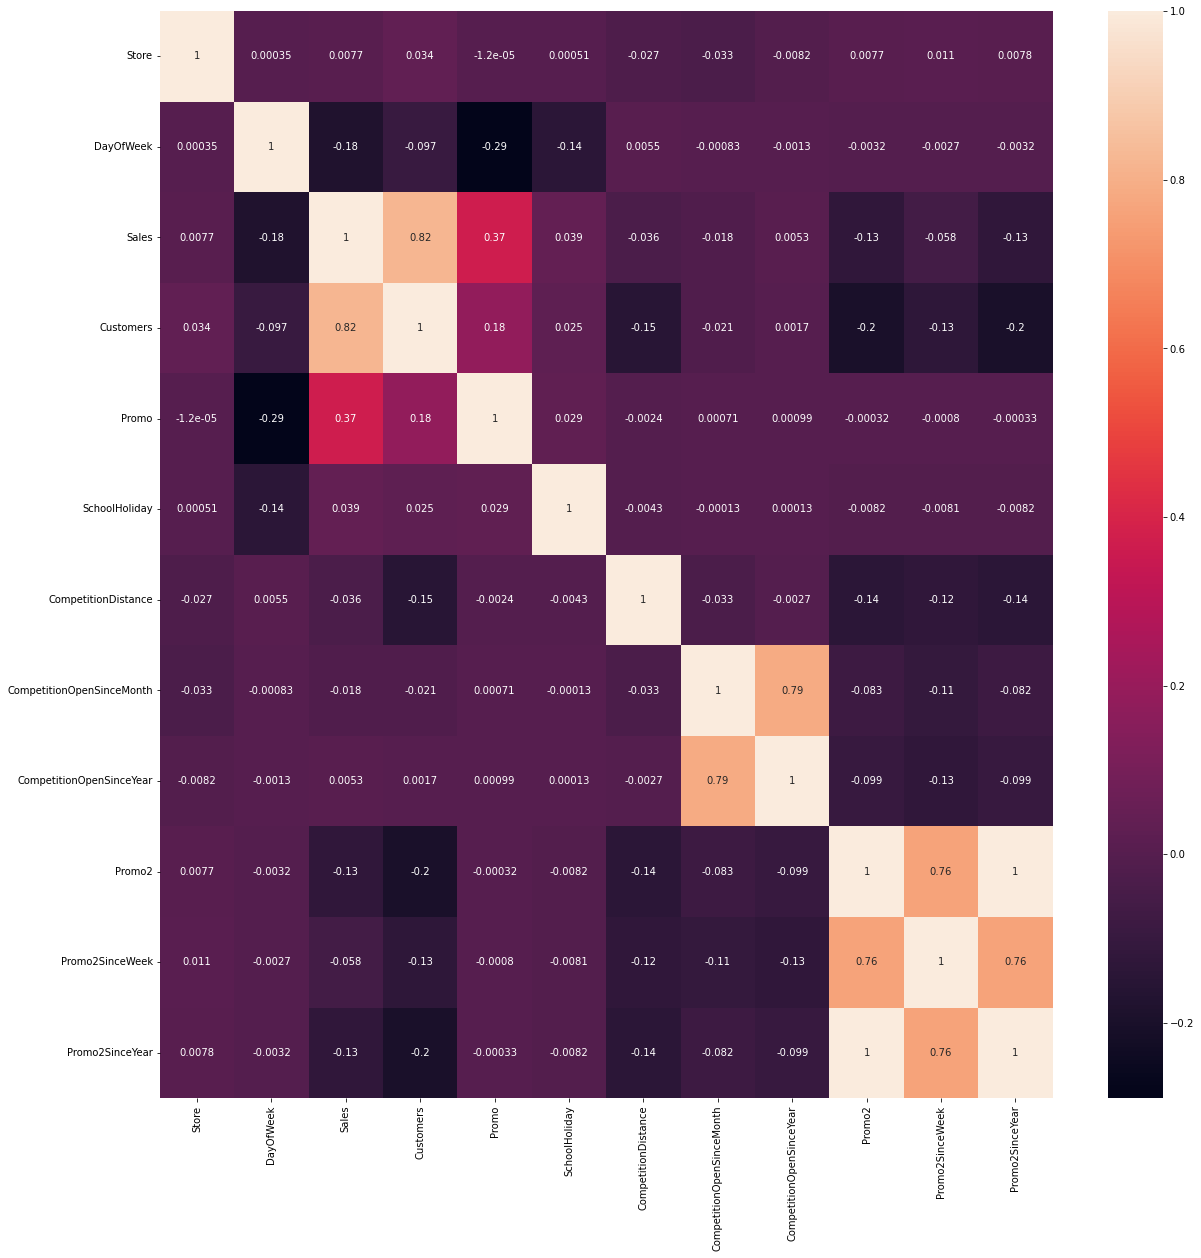

In [41]:
correlations = sales_train_all_df.corr()
f, ax = plt.subplots(figsize = (20, 20))
sns.heatmap(correlations, annot = True)
plt.show()
# Customers/Prmo2 and sales are strongly correlated 

In [42]:
# Let's separate the year and put it into a separate column 
sales_train_all_df['Year'] = pd.DatetimeIndex(sales_train_all_df['Date']).year

In [43]:
sales_train_all_df

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year
0,1,5,2015-07-31,5263,555,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015
1,1,4,2015-07-30,5020,546,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015
2,1,3,2015-07-29,4782,523,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015
3,1,2,2015-07-28,5011,560,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015
4,1,1,2015-07-27,6102,612,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844387,292,1,2013-01-07,9291,1002,1,0,0,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0,2013
844388,292,6,2013-01-05,2748,340,0,0,0,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0,2013
844389,292,5,2013-01-04,4202,560,0,0,1,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0,2013
844390,292,4,2013-01-03,4580,662,0,0,1,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0,2013


In [44]:
# Let's do the same for the Day and Month
sales_train_all_df['Month'] = pd.DatetimeIndex(sales_train_all_df['Date']).month
sales_train_all_df['Day'] = pd.DatetimeIndex(sales_train_all_df['Date']).day

In [45]:
sales_train_all_df

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day
0,1,5,2015-07-31,5263,555,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,31
1,1,4,2015-07-30,5020,546,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,30
2,1,3,2015-07-29,4782,523,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,29
3,1,2,2015-07-28,5011,560,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,28
4,1,1,2015-07-27,6102,612,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844387,292,1,2013-01-07,9291,1002,1,0,0,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0,2013,1,7
844388,292,6,2013-01-05,2748,340,0,0,0,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0,2013,1,5
844389,292,5,2013-01-04,4202,560,0,0,1,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0,2013,1,4
844390,292,4,2013-01-03,4580,662,0,0,1,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0,2013,1,3


Text(0.5, 1.0, 'Average Customers Per Month')

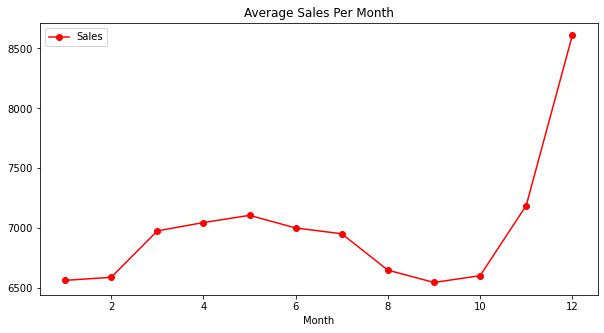

<Figure size 432x288 with 0 Axes>

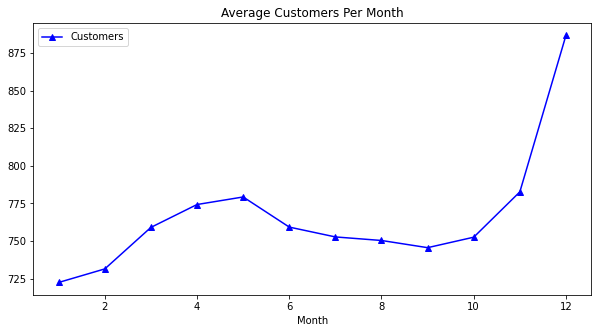

In [46]:
# Let's take a look at the average sales and number of customers per month 
# 'groupby' works great by grouping all the data that share the same month column, then obtain the mean of the sales column  
# It looks like sales and number of customers peak around christmas timeframe
axis = sales_train_all_df.groupby('Month')[['Sales']].mean().plot(figsize = (10,5), marker = 'o', color = 'r')
axis.set_title('Average Sales Per Month')

plt.figure()
axis = sales_train_all_df.groupby('Month')[['Customers']].mean().plot(figsize = (10,5), marker = '^', color = 'b')
axis.set_title('Average Customers Per Month')


Text(0.5, 1.0, 'Average Sales Per Day')

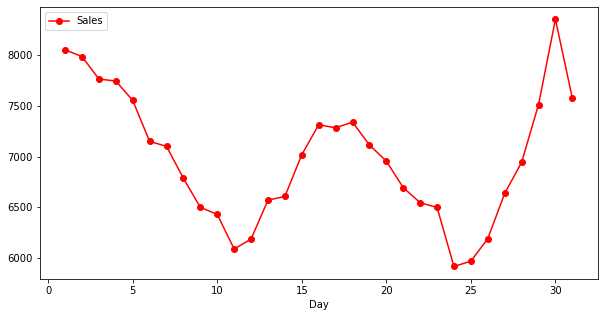

<Figure size 432x288 with 0 Axes>

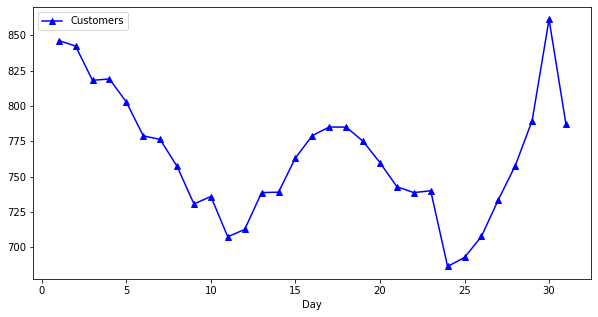

In [47]:
# Let's take a look at the sales and customers per day of the month instead
# Minimum number of customers are generally around the 24th of the month 
# Most customers and sales are around 30th and 1st of the month
ax = sales_train_all_df.groupby('Day')[['Sales']].mean().plot(figsize = (10,5), marker = 'o', color = 'r')
axis.set_title('Average Sales Per Day')

plt.figure()
ax = sales_train_all_df.groupby('Day')[['Customers']].mean().plot(figsize = (10,5), marker = '^', color = 'b')
axis.set_title('Average Sales Per Day')


Text(0.5, 1.0, 'Average Customers Per Day of the Week')

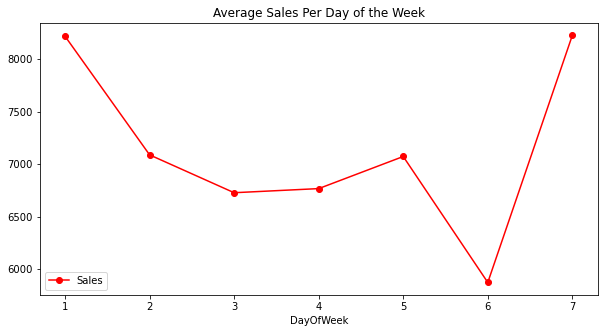

<Figure size 432x288 with 0 Axes>

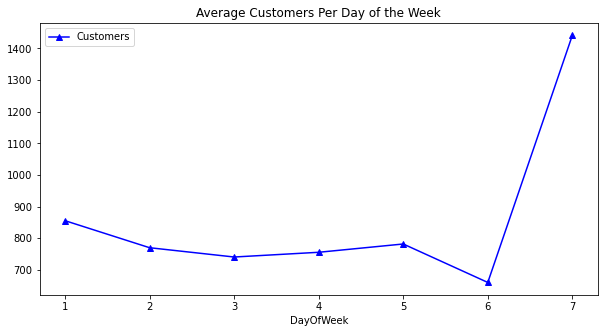

In [48]:
# Let's do the same for the day of the week  (note that 7 = Sunday)

axis = sales_train_all_df.groupby('DayOfWeek')[['Sales']].mean().plot(figsize = (10,5), marker = 'o', color = 'r')
axis.set_title('Average Sales Per Day of the Week')

plt.figure()
axis = sales_train_all_df.groupby('DayOfWeek')[['Customers']].mean().plot(figsize = (10,5), marker = '^', color = 'b')
axis.set_title('Average Customers Per Day of the Week')


<AxesSubplot:xlabel='Date'>

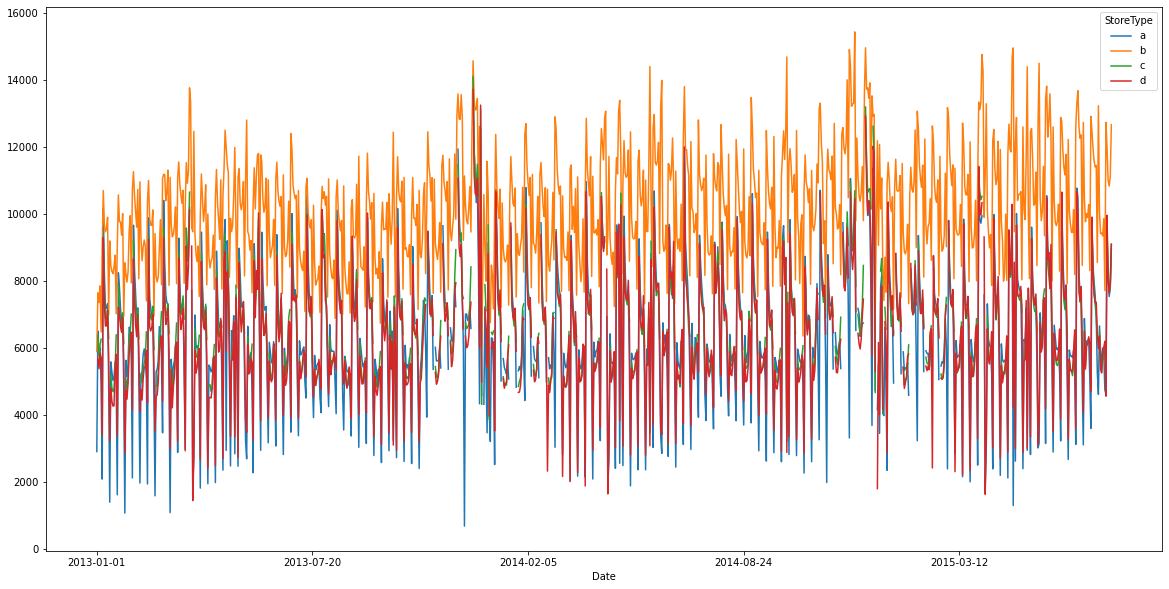

In [49]:
fig, ax = plt.subplots(figsize=(20,10))
sales_train_all_df.groupby(['Date','StoreType']).mean()['Sales'].unstack().plot(ax=ax)

<AxesSubplot:xlabel='Promo', ylabel='Customers'>

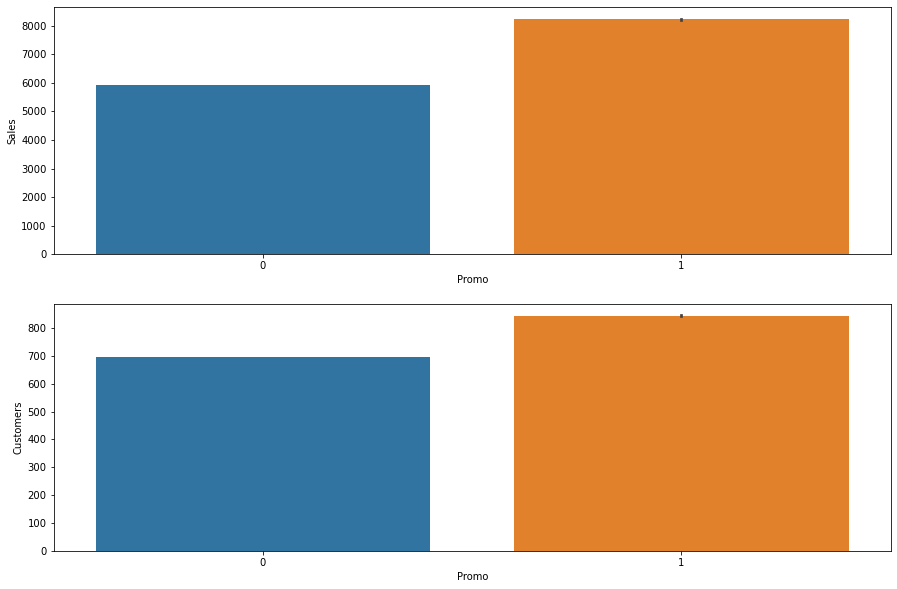

In [50]:
plt.figure(figsize=[15,10])

plt.subplot(211)
sns.barplot(x = 'Promo', y = 'Sales', data = sales_train_all_df)

plt.subplot(212)
sns.barplot(x = 'Promo', y = 'Customers', data = sales_train_all_df)

<AxesSubplot:xlabel='Promo', ylabel='Customers'>

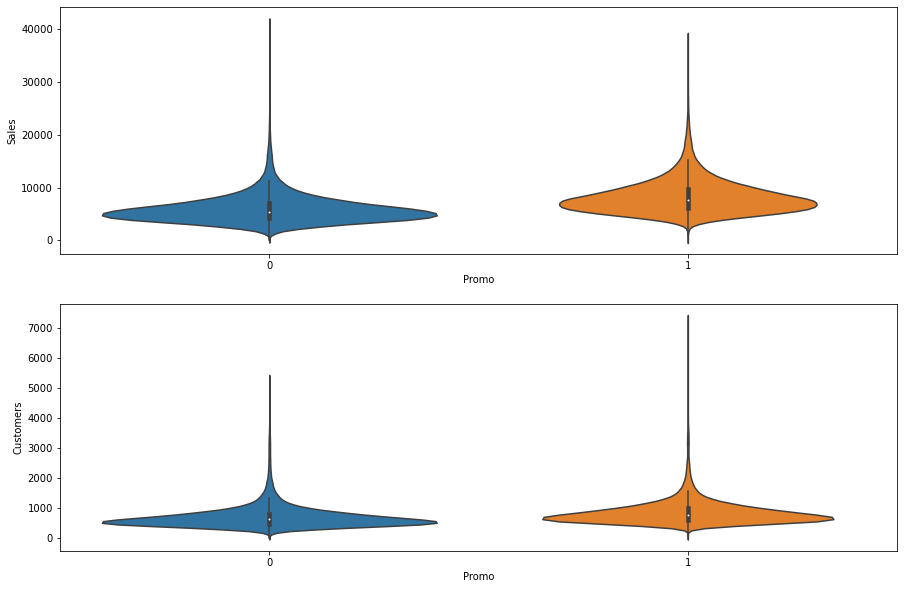

In [51]:
plt.figure(figsize=[15,10])

plt.subplot(211)
sns.violinplot(x = 'Promo', y = 'Sales', data = sales_train_all_df)

plt.subplot(212)
sns.violinplot(x = 'Promo', y = 'Customers', data = sales_train_all_df)

# Build Local Model for one Store

In [52]:
from neuralprophet import NeuralProphet
from neuralprophet import set_random_seed
set_random_seed(123)

In [53]:
sales_train_all_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day
0,1,5,2015-07-31,5263,555,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,31
1,1,4,2015-07-30,5020,546,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,30
2,1,3,2015-07-29,4782,523,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,29
3,1,2,2015-07-28,5011,560,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,28
4,1,1,2015-07-27,6102,612,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,27


In [54]:
Store_ID = 10
sales_df = sales_train_all_df[ sales_train_all_df['Store'] == Store_ID ]
sales_df = sales_df[['Date', 'Sales','Customers','Promo']].rename(columns = {'Date': 'ds', 'Sales':'y'})
sales_df['ds'] = pd.DatetimeIndex(sales_df['ds'])
sales_df = sales_df.sort_values('ds')
sales_df.head()

,ds,y,Customers,Promo
7819,2013-01-02,4812,521,0
7818,2013-01-03,4675,491,0
7817,2013-01-04,5114,517,0
7816,2013-01-05,4256,489,0
7815,2013-01-07,7804,751,1


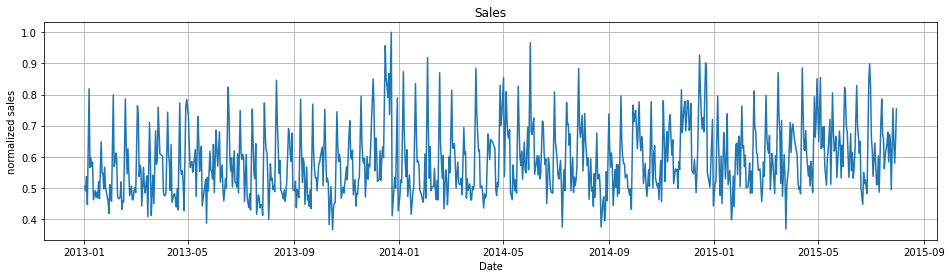

In [124]:
# plot sales
x = sales_df['ds']
y = sales_df['y'] / sales_df['y'].max()
promo = sales_df['Promo'] / sales_df['Promo'].max()
customers = sales_df['Customers'] / sales_df['Customers'].max()
plt.figure(figsize=(16,4))
#plt.plot(x, promo)
#plt.plot(x, customers)
plt.plot(x, y)
plt.title('Sales')
plt.xlabel('Date')
plt.ylabel('normalized sales')
plt.grid('on')

In [56]:
m = NeuralProphet(
    weekly_seasonality=True, 
    yearly_seasonality=True,
    n_lags=120,
    num_hidden_layers=1,
    n_forecasts=14,
    learning_rate=0.001,
    loss_func='MSE',
    ar_reg=.5, 
    epochs=200,
    batch_size=16
)

In [57]:
# add lagged regressor
m.add_lagged_regressor(names=['Customers'])

In [58]:
# add future regressor
m.add_future_regressor(name='Promo')

In [59]:
# train test split
df_train, df_test = m.split_df(sales_df, freq='D', valid_p = 0.2)
df_train.head()

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 80.867% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.forecaster.__handle_missing_data) - 157 missing dates added.
INFO - (NP.forecaster.__handle_missing_data) - 157 NaN values in column y were auto-imputed.
INFO - (NP.forecaster.__handle_missing_data) - 157 NaN values in column Customers were auto-imputed.
INFO - (NP.forecaster.__handle_missing_data) - 157 NaN values in column Promo were auto-imputed.


,ds,y,Customers,Promo
0,2013-01-02,4812.0,521.0,0.0
1,2013-01-03,4675.0,491.0,0.0
2,2013-01-04,5114.0,517.0,0.0
3,2013-01-05,4256.0,489.0,0.0
4,2013-01-06,6030.0,620.0,0.5


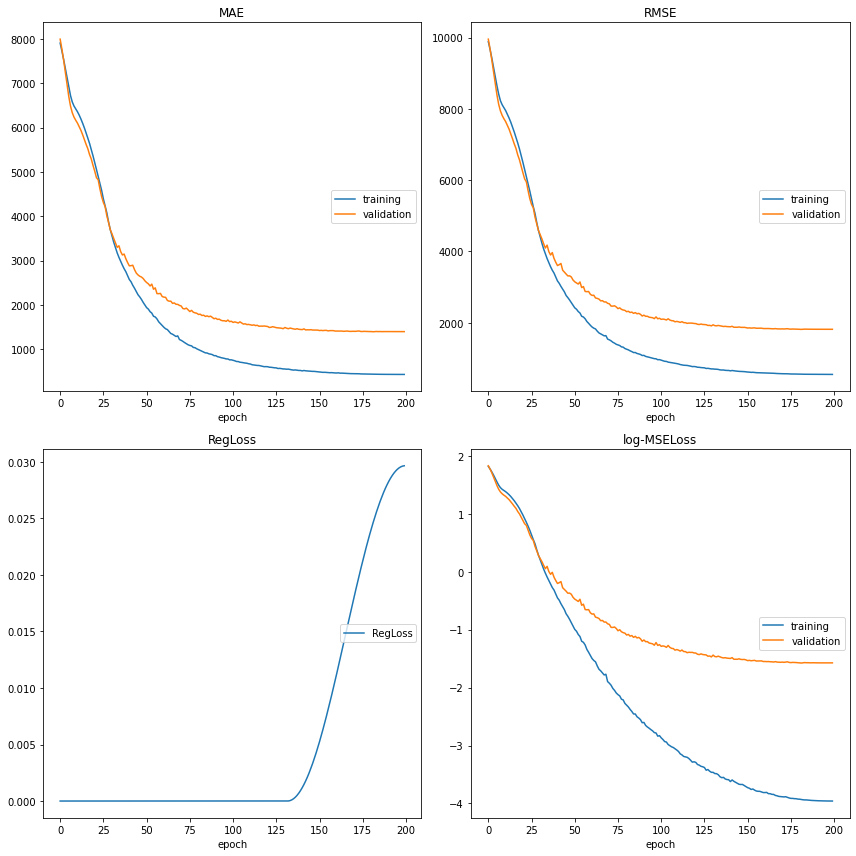

MAE
	training         	 (min:  432.726, max: 7908.079, cur:  432.726)
	validation       	 (min: 1396.023, max: 7996.020, cur: 1398.631)
RMSE
	training         	 (min:  549.088, max: 9887.279, cur:  549.559)
	validation       	 (min: 1813.530, max: 9958.192, cur: 1816.058)
RegLoss
	RegLoss          	 (min:    0.000, max:    0.030, cur:    0.030)
log-MSELoss
	training         	 (min:   -3.959, max:    1.821, cur:   -3.959)
	validation       	 (min:   -1.576, max:    1.831, cur:   -1.573)


In [60]:
# train model
metrics = m.fit(df_train, 
                freq='D', 
                validation_df=df_test, 
                progress='plot-all')

In [61]:
# make future datafrmae
future = m.make_future_dataframe(df_train,
                                 regressors_df=df_test[['Promo']],
                                 periods=20, 
                                 n_historic_predictions=len(df_train))


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.87% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
WARNING - (NP.forecaster._make_future_dataframe) - Insufficient data for 769 historic forecasts, reduced to 649.
WARNING - (NP.forecaster._make_future_dataframe) - Number of forecast steps is defined by n_forecasts. Adjusted to 14.


In [62]:
# model predict
forecast = m.predict(future)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.872% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.872% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


In [63]:
# get none null predictions
ds = forecast[forecast['yhat14'].isnull() == False]['ds']
# transform dates into list
ds = [date for date in ds]

In [64]:
x_train = df_train['ds']
y_train = df_train['y']
x_test = df_test['ds']
y_test = df_test['y']
x = forecast['ds']
y = forecast['yhat14']
yerr = forecast['residual14']
trend = forecast['trend']
season_yearly = forecast['season_yearly']
season_weekly = forecast['season_weekly']
ar = forecast['ar14']
customers  = forecast['lagged_regressor_Customers14']
promo = forecast['future_regressor_Promo']

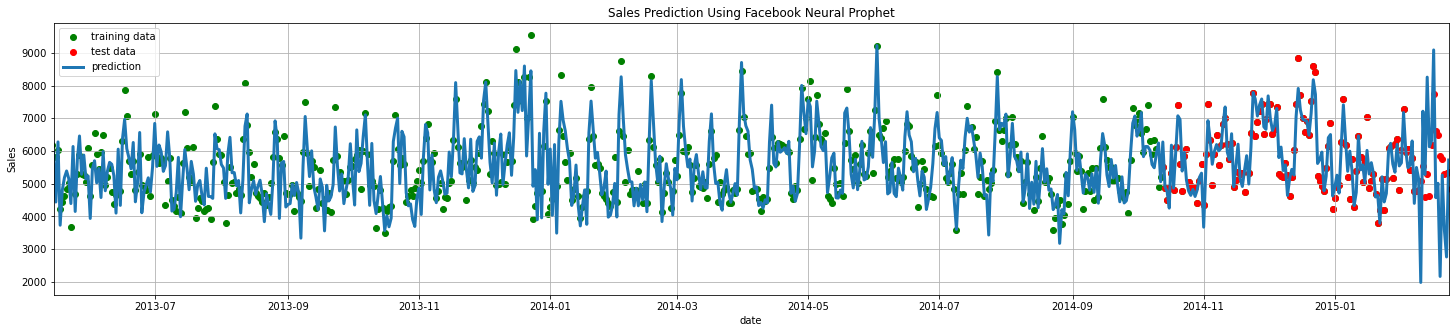

In [65]:
plt.figure(figsize=(25,5))
plt.scatter(x_train, y_train, color='g')
plt.scatter(x_test, y_test, color='r')
plt.plot(x, y, linewidth=3)
plt.xlabel('date')
plt.ylabel('Sales')
plt.title('Sales Prediction Using an Autoregressive Neural Network')
plt.grid('on')
plt.xlim(ds[0], ds[-1])
plt.legend(['training data', 'test data', 'prediction'])
plt.show()

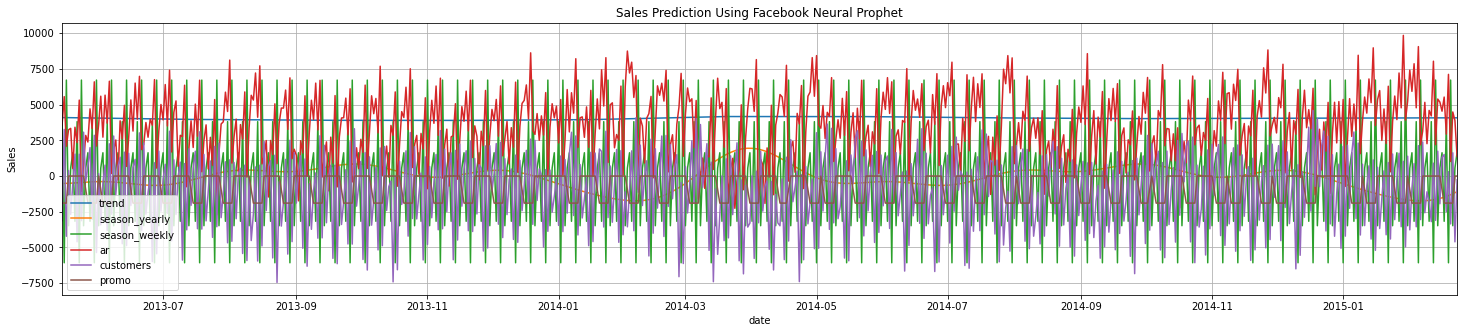

In [66]:
plt.figure(figsize=(25,5))
plt.plot(x, trend)
plt.plot(x, season_yearly)
plt.plot(x, season_weekly)
plt.plot(x, ar)
plt.plot(x, customers)
plt.plot(x, promo)
plt.xlabel('date')
plt.ylabel('Sales')
plt.title('Sales Prediction Using Facebook Neural Prophet')
plt.grid('on')
plt.xlim(ds[0], ds[-1])
plt.legend(['trend', 'season_yearly', 'season_weekly', 'ar', 'customers', 'promo'])
plt.show()

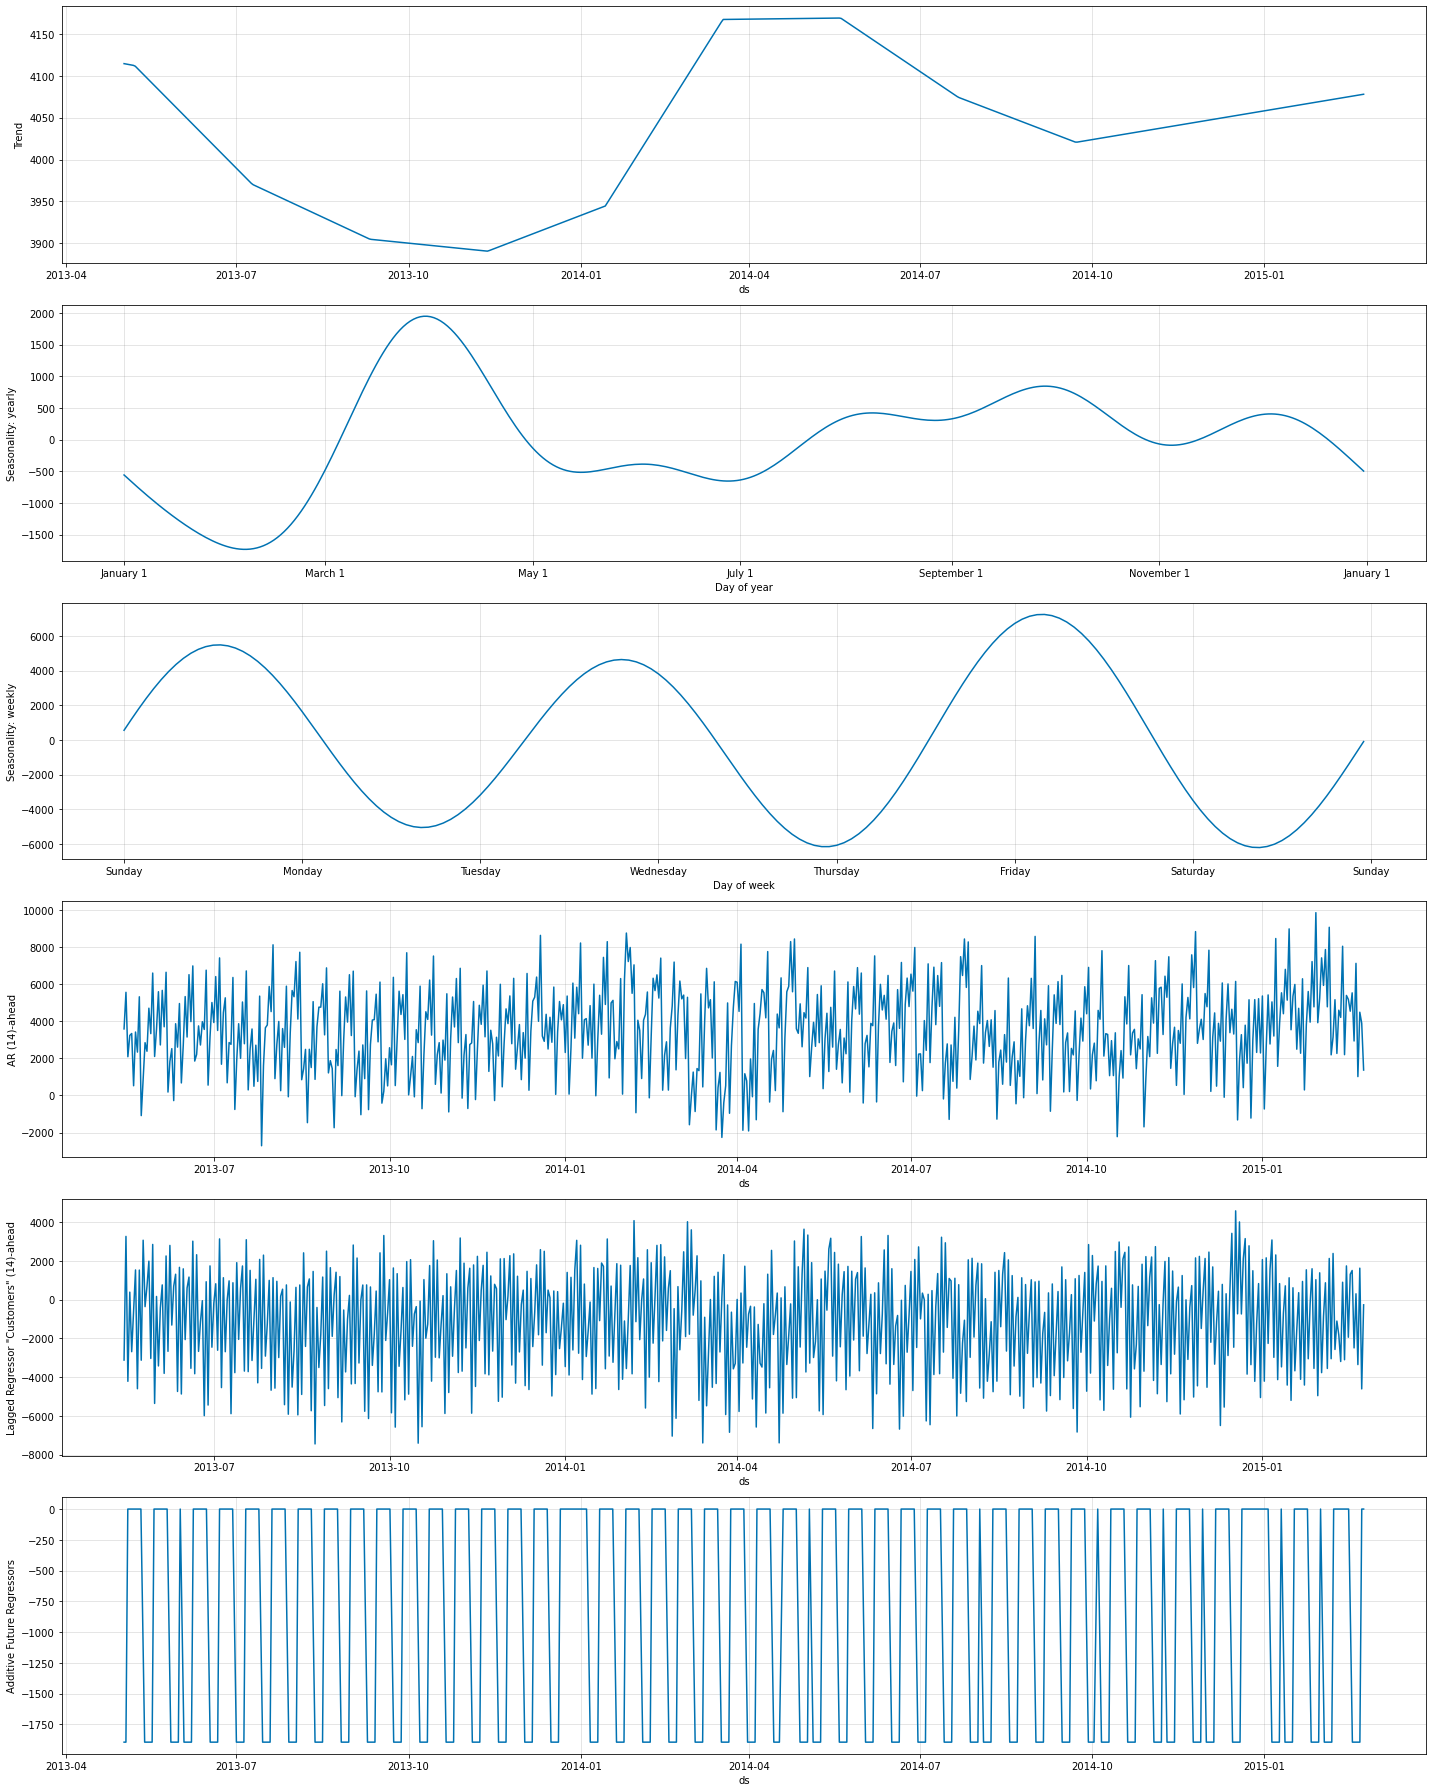

In [67]:
m = m.highlight_nth_step_ahead_of_each_forecast(14)
fig = m.plot_components(forecast, figsize=(20,25))

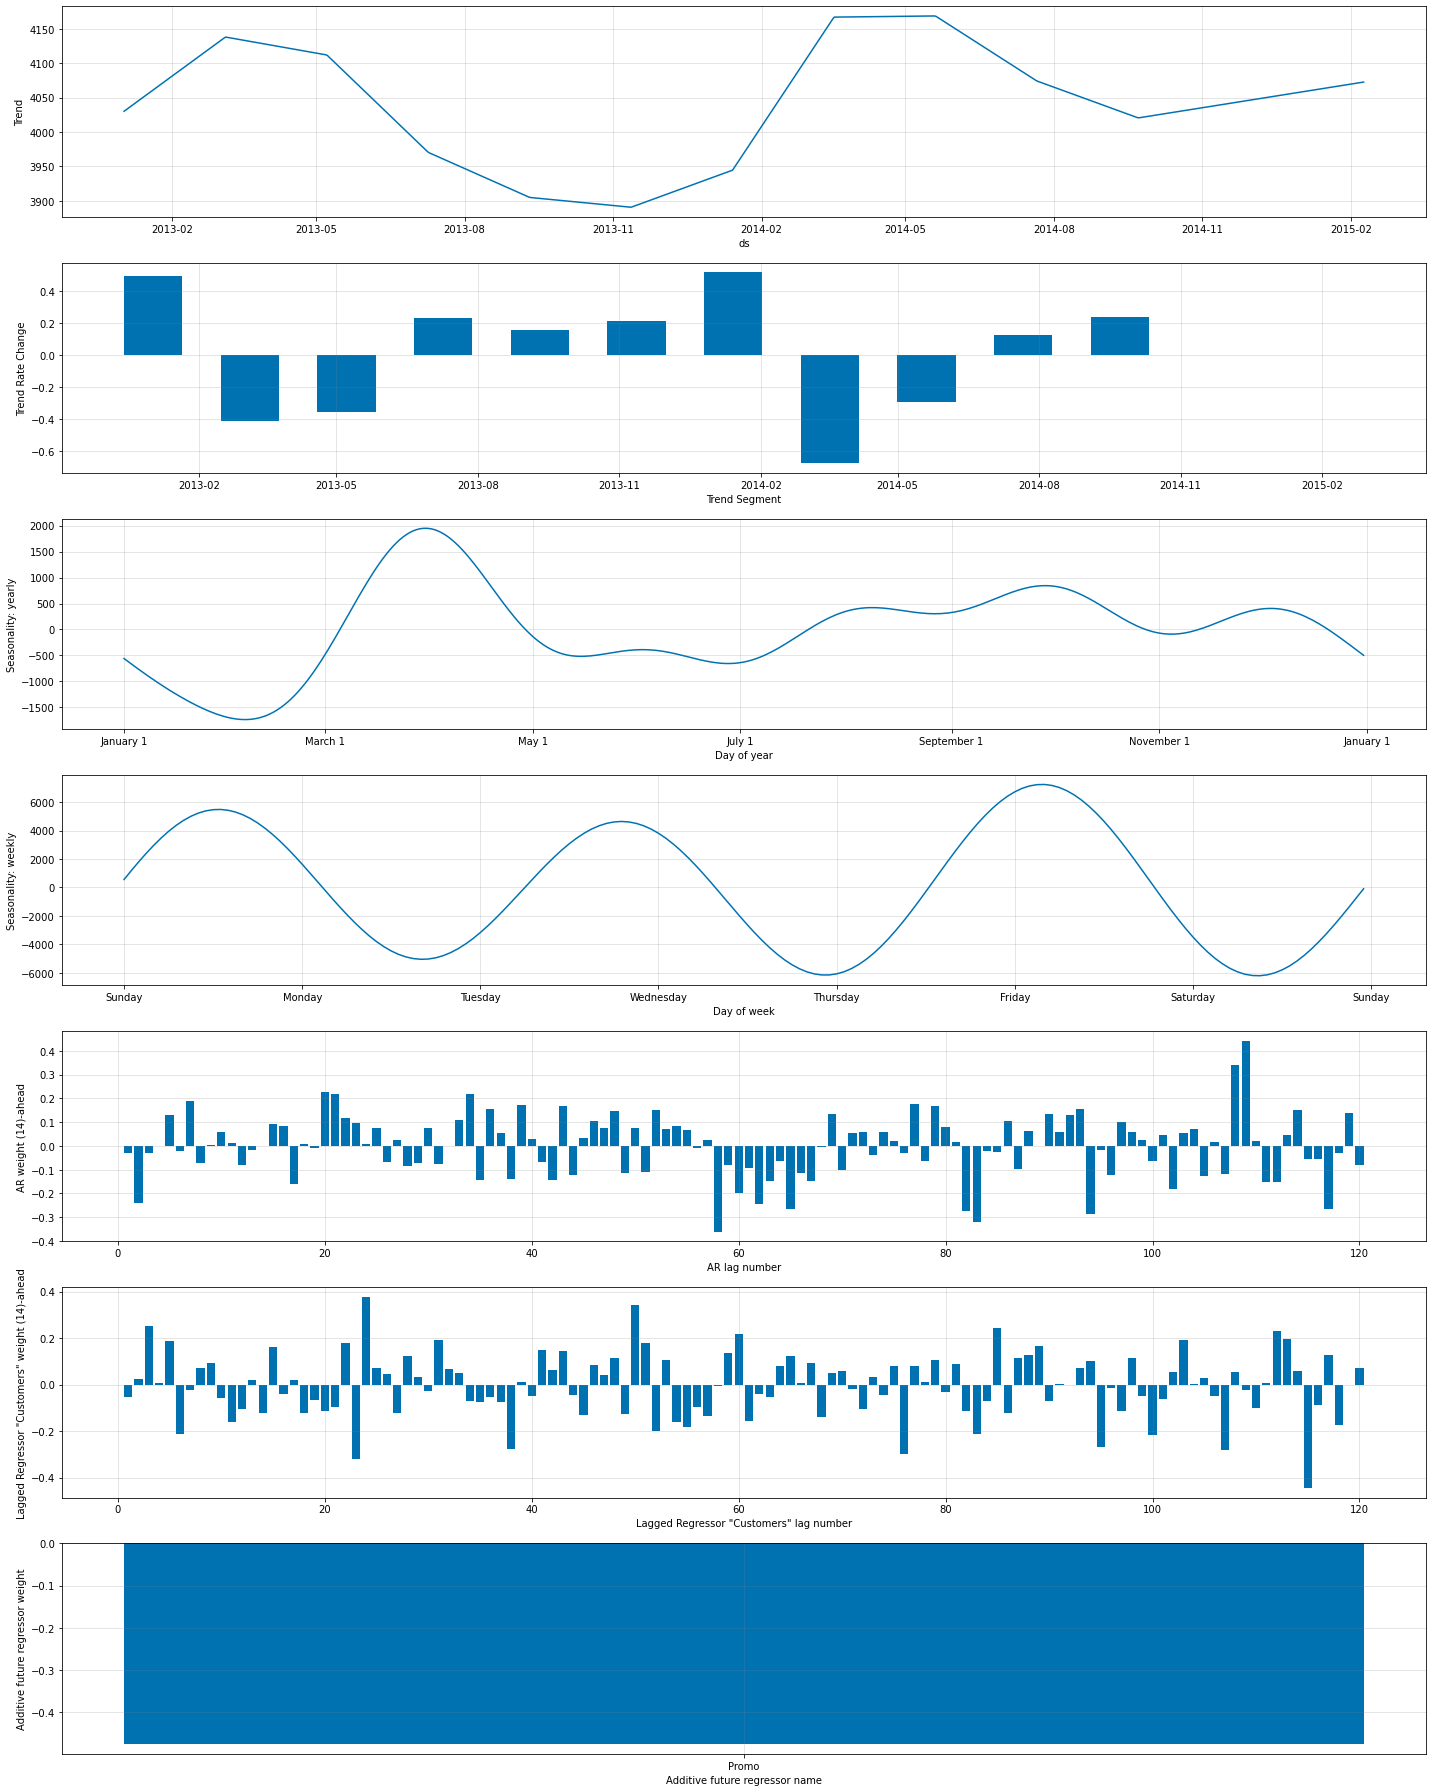

In [68]:
fig  = m.plot_parameters(figsize=(20,25))

# Build Global Model for all Stores

In [69]:
# turn date into datetime
sales_train_all_df['Date'] = pd.to_datetime(sales_train_all_df['Date'])
sales_train_all_df.sort_values(by='Date', inplace=True)
sales_train_all_df[['Date','Sales']] 

,Date,Sales
266124,2013-01-01,3139
510811,2013-01-01,3821
206921,2013-01-01,3102
197575,2013-01-01,17267
387259,2013-01-01,2646
...,...,...
637225,2015-07-31,6444
475845,2015-07-31,7544
323314,2015-07-31,6999
173401,2015-07-31,5738


In [70]:
# get list of all stores
stores = list(sales_train_all_df['Store'].unique())
stores = sorted(stores) 
len(stores)

1115

In [71]:
# let´s resample all data from all stores to be on same temporal grid
store_id = stores[0]
store_df = sales_train_all_df[sales_train_all_df['Store'] == store_id].sort_values(by='Date')
store_df = store_df.set_index('Date')
store_df = store_df.resample('D').bfill()
store_df = store_df.reset_index()
# init new df
sales_train_all_df_new = store_df

for store_id in stores:
    store_df = sales_train_all_df[sales_train_all_df['Store'] == store_id].sort_values(by='Date')
    store_df = store_df.set_index('Date')
    store_df = store_df.resample('D').ffill()
    store_df = store_df.reset_index()
    # append
    sales_train_all_df_new = sales_train_all_df_new.append(store_df)

In [72]:
# train test split
sales_df_train = sales_train_all_df_new[sales_train_all_df_new['Date'] < "2015-01-01"] 
sales_df_test = sales_train_all_df_new[sales_train_all_df_new['Date'] >= "2015-01-01"]

In [73]:
# theses are too many stores for in-memory caclulation; let´s use only n stores
stores_train = stores[:10]
stores_train

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [74]:
def get_store_df(df_all:pd.DataFrame, store_id:int, columns:list)->pd.DataFrame:
    """Return dataframe of single store given the whole df (df_all), the store id and the columns"""
    sales_df = df_all[ df_all['Store'] == store_id].copy()
    sales_df = sales_df[columns].rename(columns = {'Date': 'ds', 'Sales':'y'})
    sales_df['ds'] = pd.DatetimeIndex(sales_df['ds'])
    sales_df = sales_df.sort_values('ds')
    return sales_df

In [75]:
# put all store dfs into a dictionary
df_train_dict = {}
for store_id in stores_train:
    df_train_dict[store_id] = get_store_df(sales_df_train, store_id, ['Date', 'Sales','Customers','Promo','Promo2','CompetitionDistance'])
len(df_train_dict)

10

In [76]:
# put all store dfs into a dictionary
df_test_dict = {}
for store_id in stores_train:
    df_test_dict[store_id] = get_store_df(sales_df_test, store_id, ['Date', 'Sales','Customers','Promo','Promo2','CompetitionDistance'])
len(df_test_dict)

10

In [77]:
# for each store, we have the same value for e.g. CompetitionDistance; prophet doesn´t accept that;
# let´s do some little trick and add little noise of e.g. 5%
for store in df_train_dict.keys():
    y = df_train_dict[store]['CompetitionDistance'].values
    mean = y.mean()
    if mean==0:
        sd = 0.01
    else:
        sd = mean*0.05
    noise = np.random.normal(0,sd,len(y))
    df_train_dict[store]['CompetitionDistance'] = y + noise

    y = df_train_dict[store]['Promo2'].values
    mean = y.mean()
    if mean==0:
        sd = 0.01
    else:
        sd = mean*0.05
    noise = np.random.normal(0,sd,len(y))
    df_train_dict[store]['Promo2'] = y + noise

for store in df_test_dict.keys():
    y = df_test_dict[store]['CompetitionDistance'].values
    mean = y.mean()
    if mean==0:
        sd = 0.01
    else:
        sd = mean*0.05
    noise = np.random.normal(0,sd,len(y))
    df_test_dict[store]['CompetitionDistance'] = y + noise

    y = df_test_dict[store]['Promo2'].values
    mean = y.mean()
    if mean==0:
        sd = 0.01
    else:
        sd = mean*0.05
    noise = np.random.normal(0,sd,len(y))
    df_test_dict[store]['Promo2'] = y + noise

In [78]:
# drop duplicates in ds
for store_id in df_train_dict.keys():
    df_train_dict[store_id].drop_duplicates(subset='ds', keep='first', inplace=True)

for store_id in df_test_dict.keys():
    df_test_dict[store_id].drop_duplicates(subset='ds', keep='first', inplace=True)    

In [101]:
m = NeuralProphet(
    weekly_seasonality=True, 
    yearly_seasonality=True,
    n_lags=120,
    num_hidden_layers=1,
    n_forecasts=14,
    learning_rate=0.0001,
    loss_func='MSE',
    ar_reg=.5, 
    epochs=100,
    global_normalization=False,
    unknown_data_normalization=True
)

In [102]:
# add lagged regressor
m.add_lagged_regressor(names=['Customers'])

In [103]:
# add future regressor
m.add_future_regressor(name='Promo')
m.add_future_regressor(name='Promo2')
m.add_future_regressor(name='CompetitionDistance')

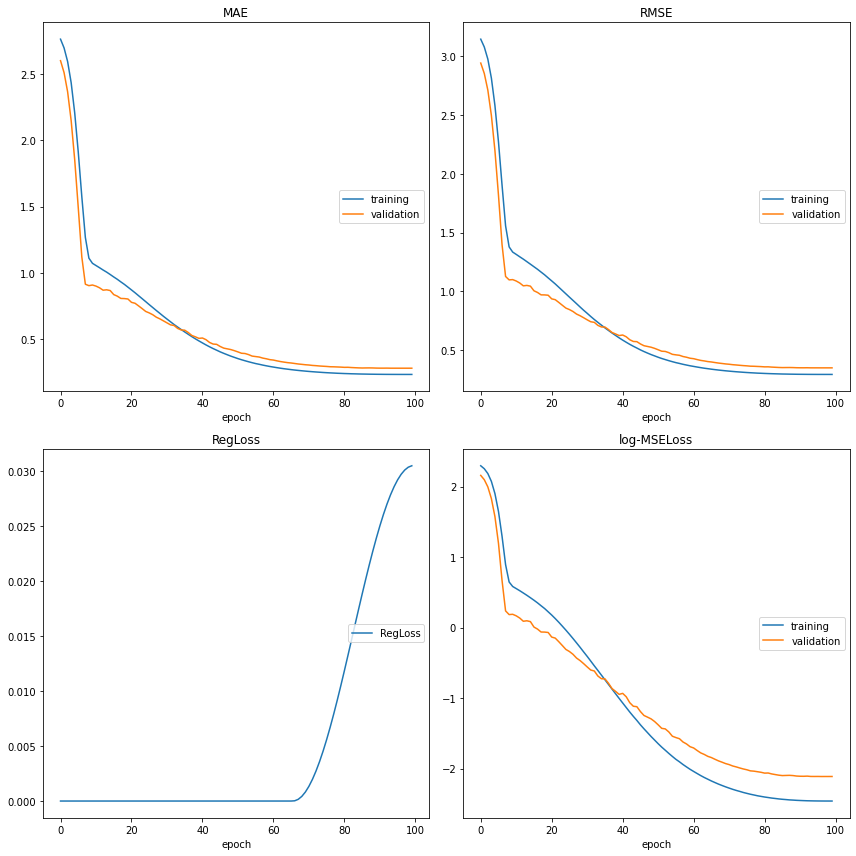

MAE
	training         	 (min:    0.232, max:    2.764, cur:    0.232)
	validation       	 (min:    0.279, max:    2.601, cur:    0.279)
RMSE
	training         	 (min:    0.292, max:    3.146, cur:    0.292)
	validation       	 (min:    0.348, max:    2.942, cur:    0.348)
RegLoss
	RegLoss          	 (min:    0.000, max:    0.030, cur:    0.030)
log-MSELoss
	training         	 (min:   -2.458, max:    2.295, cur:   -2.458)
	validation       	 (min:   -2.111, max:    2.158, cur:   -2.111)


In [104]:
# train model
metrics = m.fit(df_train_dict, 
                freq='D', 
                validation_df=df_test_dict, 
                progress='plot-all')

In [105]:
# model predict
forecast = m.predict(df_test_dict)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.528% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.528% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.528% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.528% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.528% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.528%

In [106]:
# pick single forecast
store_id = 10
df_test = df_test_dict[store_id]
forecast = forecast[store_id]


# get none null predictions
ds = forecast[forecast['yhat14'].isnull() == False]['ds']
# transform dates into list
ds = [date for date in ds]

In [107]:
x_test = df_test['ds']
y_test = df_test['y']
x = forecast['ds']
y = forecast['yhat14']
yerr = forecast['residual14']
trend = forecast['trend']
season_yearly = forecast['season_yearly']
season_weekly = forecast['season_weekly']
ar = forecast['ar14']
customers  = forecast['lagged_regressor_Customers14']
promo = forecast['future_regressor_Promo']

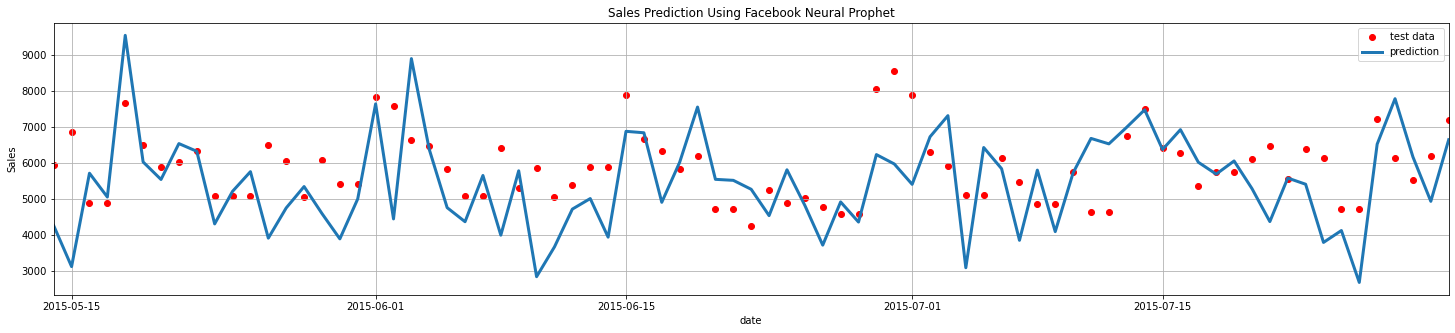

In [108]:
plt.figure(figsize=(25,5))
plt.scatter(x_test, y_test, color='r')
plt.plot(x, y, linewidth=3)
plt.xlabel('date')
plt.ylabel('Sales')
plt.title('Sales Prediction Using Facebook Neural Prophet')
plt.grid('on')
plt.xlim(ds[0], ds[-1])
plt.legend(['test data', 'prediction'])
plt.show()

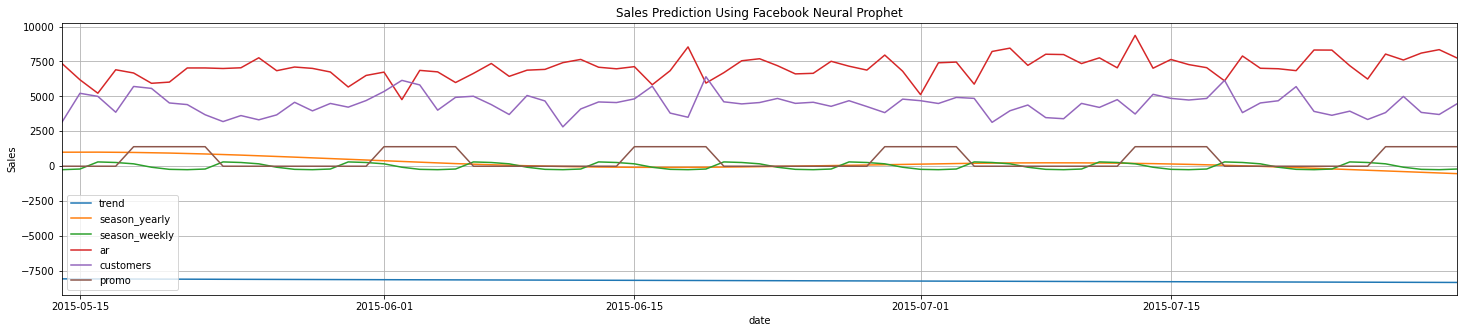

In [109]:
plt.figure(figsize=(25,5))
plt.plot(x, trend)
plt.plot(x, season_yearly)
plt.plot(x, season_weekly)
plt.plot(x, ar)
plt.plot(x, customers)
plt.plot(x, promo)
plt.xlabel('date')
plt.ylabel('Sales')
plt.title('Sales Prediction Using Facebook Neural Prophet')
plt.grid('on')
plt.xlim(ds[0], ds[-1])
plt.legend(['trend', 'season_yearly', 'season_weekly', 'ar', 'customers', 'promo'])
plt.show()

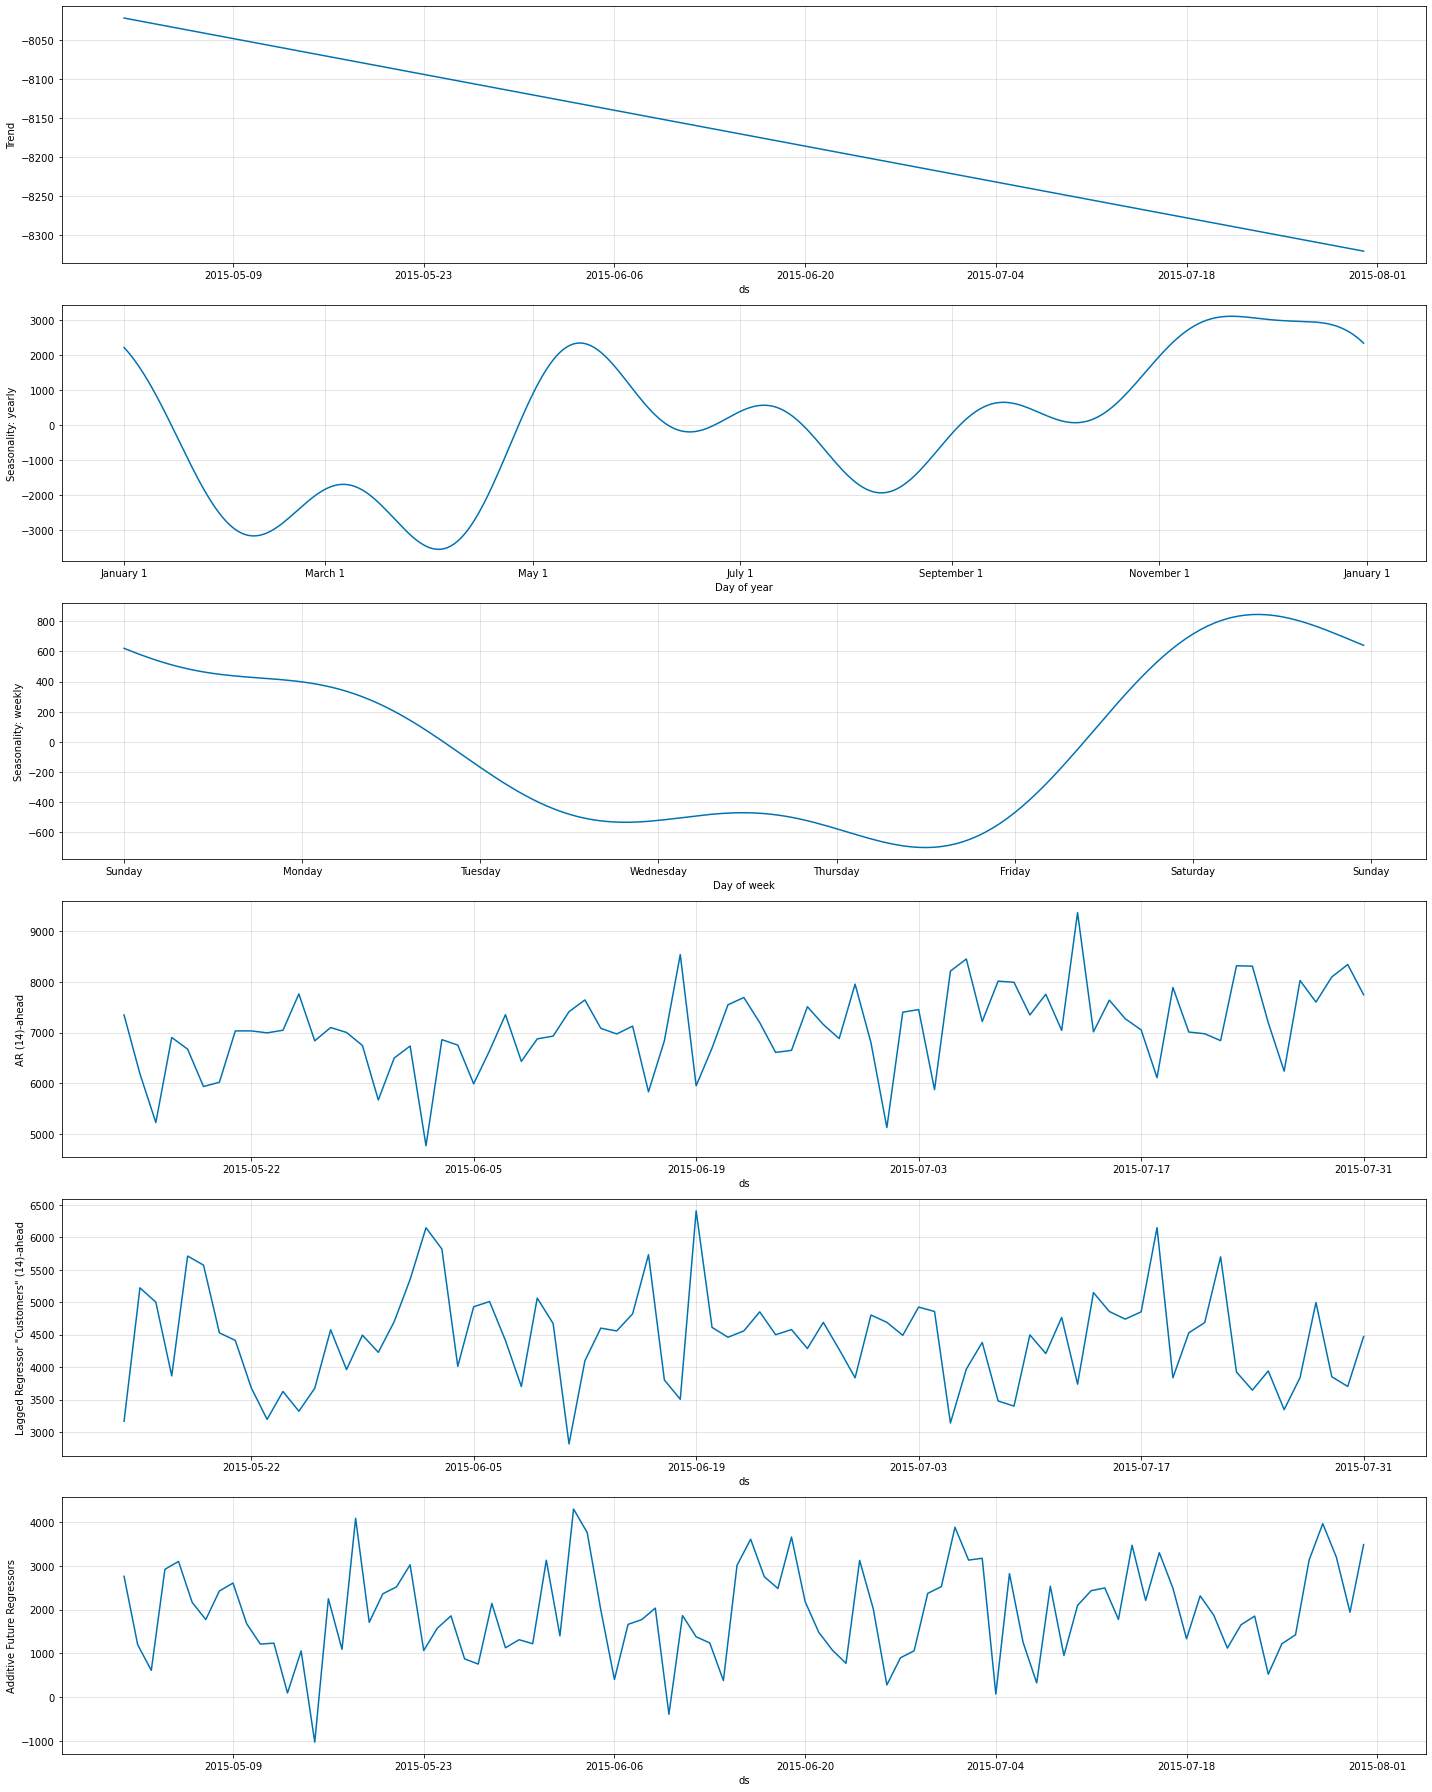

In [110]:
m = m.highlight_nth_step_ahead_of_each_forecast(14)
fig = m.plot_components(forecast, figsize=(20,25))

WARNING - (NP.plotting.plot_parameters) - Local normalization set, but df_name is None. Using global data params instead.


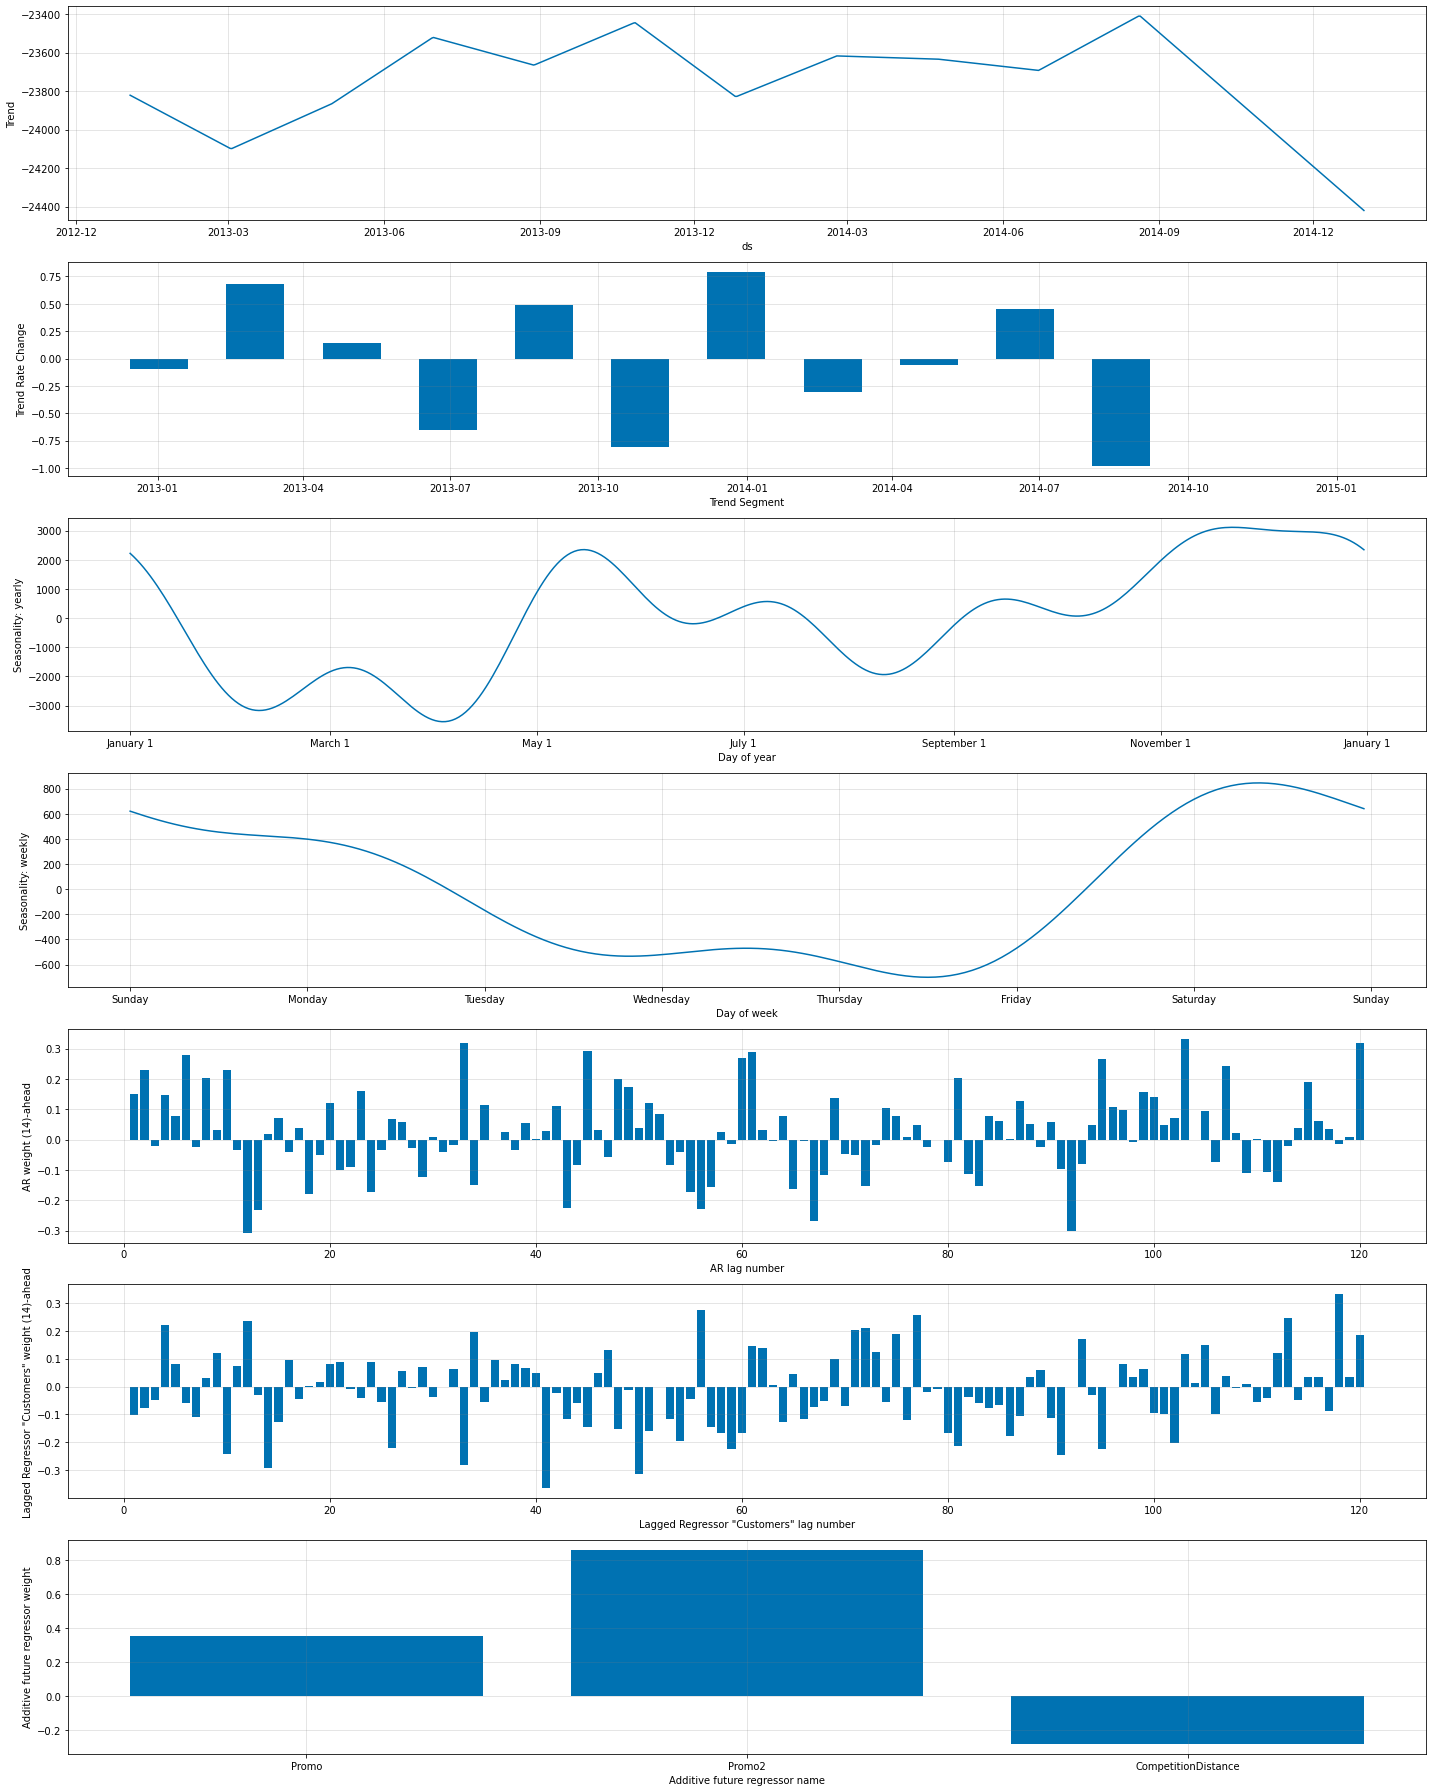

In [111]:
fig  = m.plot_parameters(figsize=(20,25))